In [44]:
from __future__ import division
from numpy import *
%pylab inline
style.use('bmh')
bmhcols=['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [45]:
def smooth(x,window_len=11,window='hanning'):
    #smooth the data using a window with requested size.
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')
    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len/2):-(window_len/2)] #y

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


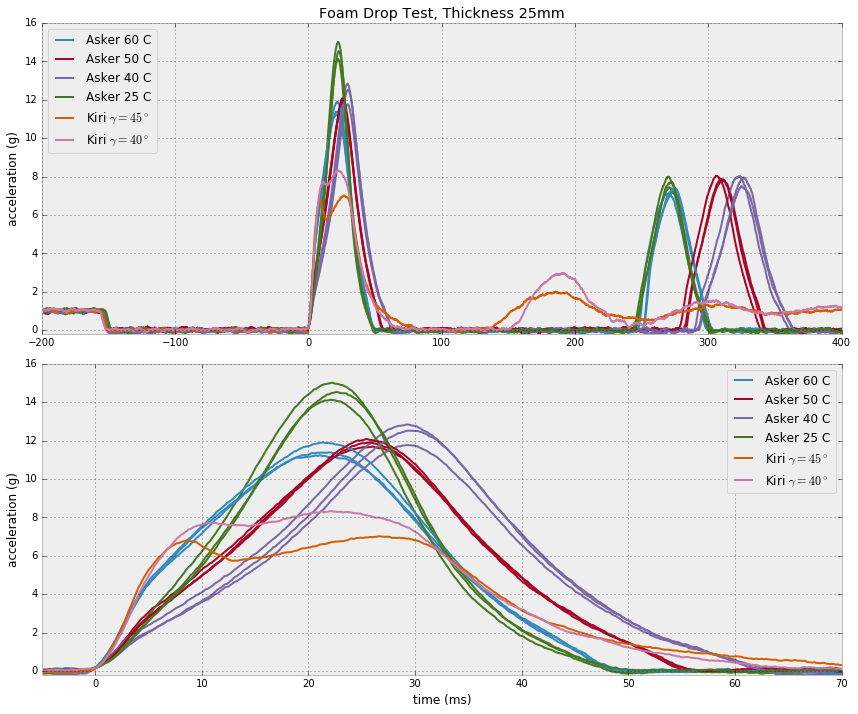

In [92]:
askers = [60,50,40,25,60,50,40,25,60,50,40,25]
labels = ["Asker %d C"%i for i in askers]
labels += [r"Kiri $\gamma=%d^\circ$"%i for i in [45,40]]
colors = [bmhcols[i] for i in [0,1,2,3,0,1,2,3,0,1,2,3,4,5]]
#colors = {60:bmhcols[0], 50:bmhcols[1], 40:bmhcols[2], 25:bmhcols[3],175:bmhcols[4],165:bmhcols[5]}
fns = ['asker-tests-25mm/ADXL%02d.TXT'%(i+17) for i,a in enumerate(askers)]
fns += ['kiri-tests/2017.5.16/kiri65.TXT','kiri-tests/2017.5.16/kiri75.TXT']

data = {}
for fn in fns:
    data[fn] = []
    with open(fn,'r') as f:
        data_start = int(f.readline().strip('\n').split(',')[1])
        voltage = f.readline().strip('\n')
        for line in f.readlines():
            data[fn].append(map(int,line.strip('\n\r').split(',')))
    data[fn] = asarray(data[fn])    
close('all')
fig,axarr = subplots(2,1,figsize=(12,10),dpi=300)
vfs = [] #final velocities
hts = [] #half flight times
for i,fn in enumerate(fns):
    times = cumsum((3./2)*data[fn][:,0])/1e3 #fix timing bug and convert to ms
    times -= times[-data_start]
    gs = (200/2**12)*data[fn][:,1]/16
    gs = smooth(gs,window_len=21,window='flat')
    
    zero_g_time = where(times>-300)[0][0]
    one_g_time = where(times<-500)[0][0]
    zero_g = average(gs[zero_g_time:zero_g_time+20])
    gs -= zero_g
    one_g = average(gs[one_g_time:one_g_time+50])
    gs /= one_g
    impact_time = where(gs[zero_g_time:]>.2)[0][0] + zero_g_time

    release_time = where(gs[impact_time:]<.05)[0][0] + impact_time
    dt = times[impact_time:release_time+1]-times[impact_time-1:release_time]
    dv = 9.81*1e-3*sum( dt*gs[impact_time-1:release_time] )
    vfs.append(-1+dv)
    
    next_impact_time = where(gs[release_time:]>.2)[0][0] + release_time
    hts.append( .5*(times[next_impact_time]-times[release_time]) )
    
    times -= times[impact_time]-.25

    axarr[0].plot(times,gs,label=labels[i],c=colors[i])
    axarr[1].plot(times,gs,label=labels[i],c=colors[i])
    
for ax in axarr:
    ax.set_ylabel('acceleration (g)')
    ax.set_ylim([-.2,16])
axarr[1].set_xlabel('time (ms)')
handles, labels = axarr[0].get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
axarr[0].legend(handle_list, label_list,loc='upper left')
axarr[1].legend(handle_list, label_list,loc='upper right')
axarr[0].set_xlim([-200,400]);
axarr[1].set_xlim([-5,70]);
axarr[0].set_title("Foam Drop Test, Thickness 25mm")
tight_layout()

[60, 50, 40, 25, 60, 50, 40, 25, 60, 50, 40, 25, 175, 165]


/Library/Python/2.7/site-packages/numpy-1.8.1-py2.7-macosx-10.9-intel.egg/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Library/Python/2.7/site-packages/numpy-1.8.1-py2.7-macosx-10.9-intel.egg/numpy/core/_methods.py:67: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Python/2.7/site-packages/numpy-1.8.1-py2.7-macosx-10.9-intel.egg/numpy/core/_methods.py:79: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Library/Python/2.7/site-packages/numpy-1.8.1-py2.7-macosx-10.9-intel.egg/numpy/core/_methods.py:91: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Library/Python/2.7/site-packages/numpy-1.8.1-py2.7-macosx-10.9-intel.egg/numpy/core/_methods.py:113: RuntimeWarning: invalid value encountered in double_scalars
  ret

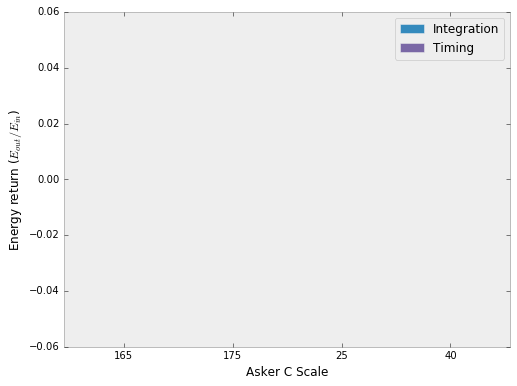

In [70]:
print askers
e_vels = asarray(vfs)**2 #energy ratio calculated by integrating acceleration
e_time = (asarray(hts)/150.)**2 #energy ratio calculated by measuring times between impacts

avg_e_vels = [average(e_vels[i::4]) for i in range(4)][::-1]
std_e_vels = [std(e_vels[i::4]) for i in range(4)][::-1]
avg_e_time = [average(e_time[i::4]) for i in range(4)][::-1]
std_e_time = [std(e_time[i::4]) for i in range(4)][::-1]

N=4
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(ind, avg_e_vels, width, color=bmhcols[0], yerr=std_e_vels,
                error_kw=dict(ecolor='k', lw=2, capsize=3, capthick=2))
rects2 = ax.bar(ind + width, avg_e_time, width, color=bmhcols[2], yerr=std_e_time,
               error_kw=dict(ecolor='k', lw=2, capsize=3, capthick=2))
ax.set_ylabel('Energy return ($E_{out}/E_{in}$)')
ax.set_xlabel('Asker C Scale')
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width)
ax.set_xticklabels(tuple(askers[::-1]))
ax.set_xlim([-.2,3.9])
grid(False)
ax.legend((rects1[0], rects2[0]), ('Integration', 'Timing'))


#plot( askers, asarray(vfs)**2, marker='o',ls='' )
#ylim([0,1.])
#xlabel("Asker C Scale")
#ylabel("Energy return ($E_{out}/E_{in}$)")

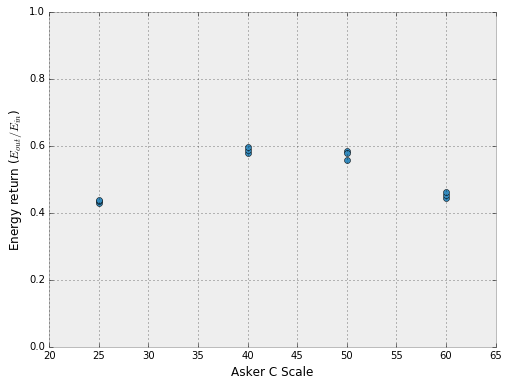

In [443]:
figure(figsize=(8,6))
plot( askers, (asarray(hts)/150.)**2, marker='o',ls='' )
ylim([0,1.])
xlim([20,65])
xlabel("Asker C Scale")
ylabel("Energy return ($E_{out}/E_{in}$)")

data_start,2069
battery_voltage,3.92
data_start,2819
battery_voltage,3.92


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


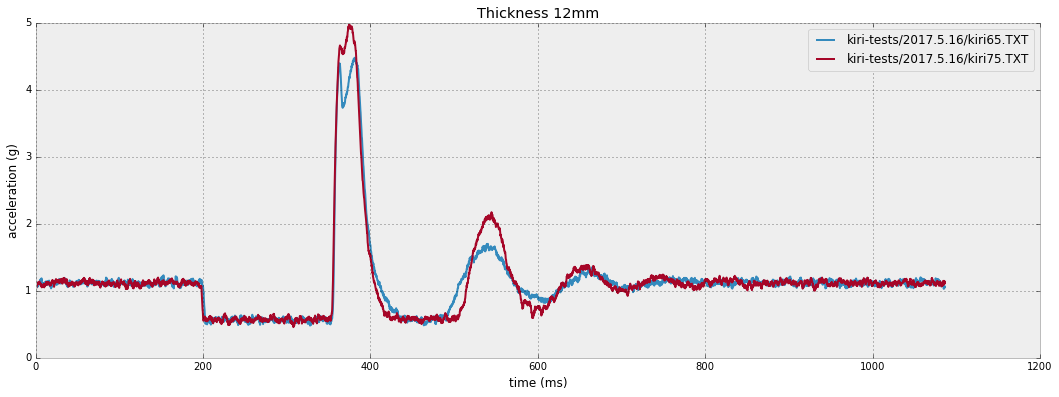

In [57]:
#fns = ['kiri-tests/kiri-test-fail.TXT','kiri-tests/kiri-35-pp-017.TXT']
#fns = ['kiri-tests/kiri-35-pp-017.TXT']
fns = ['kiri-tests/2017.5.16/kiri65.TXT','kiri-tests/2017.5.16/kiri75.TXT']

data = {}
for fn in fns:
    data[fn] = []
    with open(fn,'r') as f:
        print f.readline().strip('\n')
        print f.readline().strip('\n')
        for line in f.readlines():
            data[fn].append(map(int,line.strip('\n\r').split(',')))
    data[fn] = asarray(data[fn])    
figure(figsize=(18,6))
for fn in fns:
    times = cumsum((3./2)*data[fn][:,0])/1e3
    gs = (200/2**12)*data[fn][:,1]/16
    #gs = data[fn][:,1]/16
    gs = smooth(gs,window_len=13,window='flat')
    #detect impact
    #impact = where(gs[20:]-gs[:-20] > 3)[0][0]
    #print impact
    plot(times,gs,label='%s'%fn)
xlabel('time (ms)')
ylabel('acceleration (g)')
legend(loc='upper right')
#xlim([350,700])
#xlim([amin(times),amax(times)]);
title("Thickness 12mm")

In [147]:
d = data[fns[-1]]
#1/((d[1:,0]-d[:-1,0])*1e-6)
(d[1:,0]-d[:-1,0])

array([120, 120, 120, ..., 120, 121, 121])

In [149]:
1e6/5500

181.8181818181818

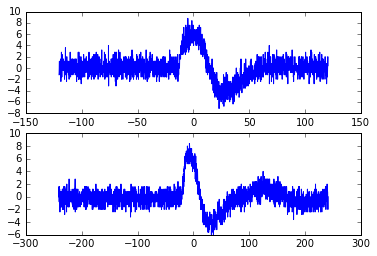

In [132]:
fig,axarr = subplots(2,1)
for i in [0,1]:
    axarr[i].plot(data[fns[i]][:,0]/1e3,data[fns[i]][:,1]/40)

In [111]:
freq = 1e3/(times[1:]-times[:-1])
print average(freq), std(freq)

8295.43916903 45.3503565643


In [102]:
gs

array([ 0.05714286,  0.11428571,  0.05714286, ..., -0.20952381,
       -0.13333333, -0.15238095])

In [114]:
#integrate over series
dv = sum(gs)*.12e-3 #change in velocity (m/s)
dv

-0.0079117037037036344

In [141]:
2.75*2

5.5

In [192]:
def square(x,nmin=1,nmax=100):
    k = arange(nmin,nmax).reshape(-1,1)
    return (4/pi)*sum( sin(2*pi*(2*k-1)*x)/(2*k-1)  , axis=0)

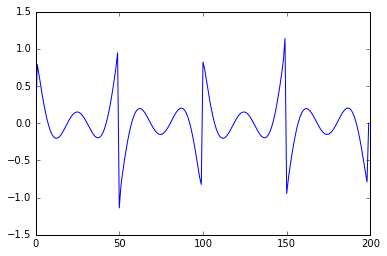

In [198]:
x = linspace(-1,1,200)
plot(square(x,nmin=3,nmax=100))

In [312]:
tmin = -144335
tmax = 433315
(tmax-tmin)/2**16

8.814239501953125

In [317]:
dt = times[1:]-times[:-1]
amin(dt), amax(dt), average(dt), std(dt)

(0.1169999999999618,
 0.12399999999999523,
 0.12036882683892487,
 0.00072019892819037484)

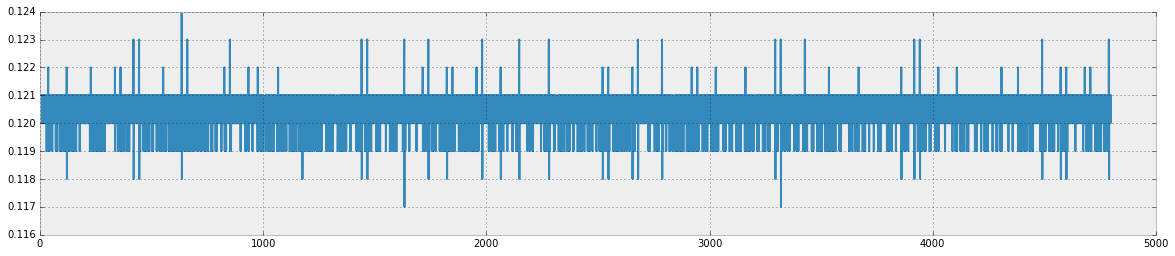

In [322]:
figure(figsize=(20,4))
plot(dt)

0.0509683995923


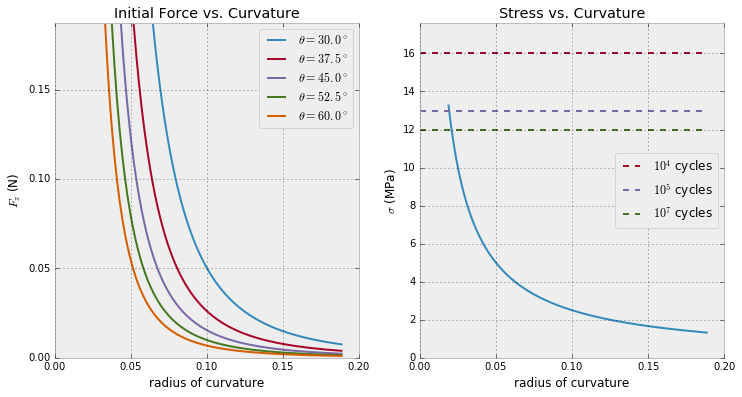

In [29]:
#approximating initital stiffness of curve crease kiricombs
#parameterize the bending of a plate by a bending radius r (m)
#z is the height (perp to bend)
#t is thickness, E is elastic modulus, 
#l is total length perp to bend axis
#w is length parallel to bend axis
#th is the half the angle through with the bend occurs. (beta)
l = .003 #meters
#e = .01 #meters
#th = pi/4 #radians
w = .01 #meters
E = 1e9 #Pa
t = .0005 #.0005 #meters
N = 10
def e(r,th,l):
    return .5*l-th*r
def dedr(r,th,l):
    return -th
def z(r,th,l):
    #return 2*r*sin(l/(2*r)) + 2*e*cos(l/(2*r))
    return 2*r*sin(th) + 2*e(r,th,l)*cos(th)
def dzdr(r,th,l):
    #return 2*sin(l/(2*r)) - (l/r)*cos(l/(2*r)) + e*l/r**2*sin(l/(2*r))
    return 2*sin(th) - th*2*cos(th)
def U(r,l):
    return t**3/(32*r**2)*l*w*E
def dUdr(r,l):
    return -t**3/(16*r**3)*l*w*E
def Fz(r,th,l):
    return -dUdr(r,l)/dzdr(r,th,l)
def stress(r):
    return E*t/(2*r)

cycles = [4,5,7] #for 10^X cycles
cycle_stresses = [16,13,12] #Mpa, Cyclic Fatigue and Thermal Softening of Polypropylene

fig,axarr = subplots(1,2,figsize=(12,6))
ths = linspace(pi/6.,pi/3,5)
l = .006
r = linspace(pi*l,10*pi*l,200)
for th in ths:
    axarr[0].plot(r,N*Fz(r,th,l),label=r'$\theta=%.1f^\circ$'%(180*th/pi))
axarr[1].plot(r,stress(r)/1e6)
for c,cs in zip(cycles,cycle_stresses):
    axarr[1].plot([0, amax(r)],[cs,cs],ls='--',label='$10^%d$ cycles'%c)

axarr[0].set_title('Initial Force vs. Curvature')
axarr[0].set_xlabel('radius of curvature')
axarr[0].set_ylabel('$F_z$ (N)')
axarr[0].set_ylim([0,1.1*amax(N*Fz(r,th,ls[0]))])
axarr[0].legend(loc='upper right')

axarr[1].set_title('Stress vs. Curvature')
axarr[1].set_xlabel('radius of curvature')
axarr[1].set_ylabel('$\sigma$ (MPa)')
axarr[1].set_ylim([0,1.1*amax(cycle_stresses)])
axarr[1].legend(loc='center right')


In [40]:

#From http://onlinelibrary.wiley.com/doi/10.1111/jiec.12589/full
# "Energy Consumption Modeling of Stereolithography-Based Additive Manufacturing 
# Toward Environmental Sustainability"
# we have specific energy consumptions from 30-200 kWh/kg.

mj_per_kwh = 3.6
rho = 1 #g/cm^3
def convert(kwh_per_kg):
    result = kwh_per_kg*mj_per_kwh / 1000 * rho
    print "%.2f kWh/kg = %.3f MJ/cm^3"%(kwh_per_kg, result)
convert(200)

200.00 kWh/kg = 0.720 MJ/cm^3


In [42]:
#this same study quotes about 7 seconds per layer, and a layer height of 25 um.
#Thus, volumetric process rate depends on cross sectional area.
def process_rate(area,t_layer=7,h_layer=.025):
    #area (mm^2), t_layer (s), h_layer (mm)
    return area*h_layer / t_layer / 1000 #cm^3/s
"Process Rate: %.2e cm^3/s"%process_rate(100)

'Process Rate: 3.57e-04 cm^3/s'

In [ ]:
#This does not fall on the linear relationship between these two parameters established in 
#http://web.mit.edu/2.813/www/readings/Gutowski-CIRP.pdf


In [ ]:
#what would an energy expression for bending look like?  We have the following effects to use:
# 1. poisson effects -- depends on boundary conditions
# 2. hinge stiffness
# 3. panel stiffness
#can we integrate the last two over z?
#for the former, what can we do?  
#  best for impact is to assume friction immobilizes.  
#  easiest to model is to assume no friction
#  for hinge stiffness, is the angle rho? or what coordinate system is it relevant to...
#  can we incorporate thickness effects into this?  do hinges stretch?


#is there an equivalent zero poisson polyhedron to use?